# 5. Visualizing movement models in epymorph

epymorph expresses a model's movement dynamics as Movement Models: modular components which support rapid experimentation and comparison. To help visualize the differences between movements models, we can plot their concepts of movement probability between geographic nodes.

We'll use the same counties scope we created in part 3.

In [1]:
import numpy as np

from epymorph.kit import *
from epymorph.geography.us_census import STATE

# Create our scope: the counties in our four states.
scope = CountyScope.in_states(["AZ", "NM", "CO", "UT"], year=2020)

# We can extract the state fips codes from the county fips codes.
state_fips = {STATE.truncate(x) for x in scope.node_ids}

# Find Maricopa County's index in the geo
([MARICOPA_CO_IDX],) = np.where(scope.node_ids == "04013")

## Centroids movement

Although a movement model normally encapsulates this detail, we'll "extract" its movement kernel here so we can map one row of it.

In [2]:
import numpy as np

from epymorph.adrio import us_tiger
from epymorph.util import pairwise_haversine, row_normalize

with sim_messaging():
    phi = 40.0
    centroid = us_tiger.GeometricCentroid().with_context(scope=scope).evaluate()
    distance = pairwise_haversine(centroid)
    log_centroids_kernel = np.log(row_normalize(1 / np.exp(distance / phi)))

Loading epymorph.adrio.us_tiger.GeometricCentroid:
  |####################| 100%  (7.674s)


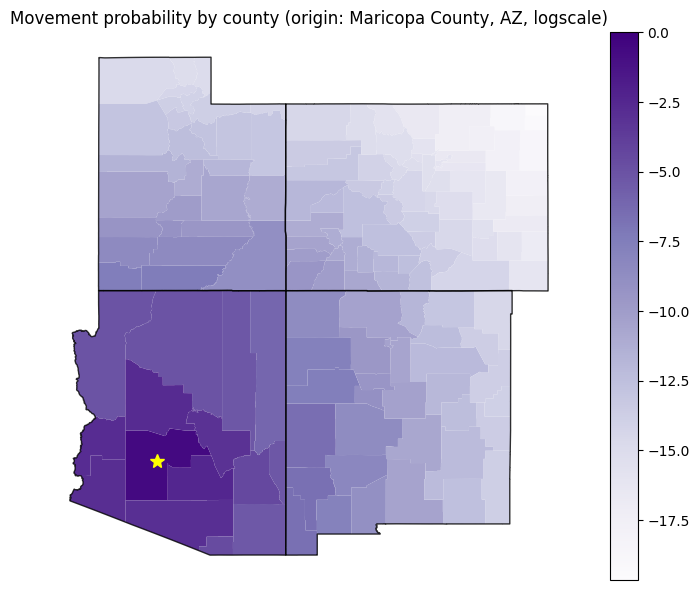

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

state_fips = tuple({STATE.truncate(x) for x in scope.node_ids})
gdf_counties = us_tiger.get_counties_geo(scope.year)  # type:ignore
gdf_counties = gdf_counties[gdf_counties["GEOID"].str.startswith(state_fips)]

gdf_states = us_tiger.get_states_geo(scope.year)  # type:ignore
gdf_states = gdf_states[gdf_states["GEOID"].str.startswith(state_fips)]

gdf_merged = gdf_counties.merge(
    pd.DataFrame(
        {
            "GEOID": scope.node_ids,
            "data": log_centroids_kernel[MARICOPA_CO_IDX],
        }
    ),
    on="GEOID",
)

fig, ax = plt.subplots(figsize=(8, 6))
ax.axis("off")
ax.set_title("Movement probability by county (origin: Maricopa County, AZ, logscale)")
gdf_merged.plot(ax=ax, column="data", cmap="Purples", legend=True, vmax=0)
gdf_states.plot(ax=ax, linewidth=1, edgecolor="black", color="none", alpha=0.8)
# Get Maricopa County's centroid from the geo so we can mark it.
origin = centroid[MARICOPA_CO_IDX]
ax.plot(origin[0], origin[1], marker="*", color="yellow", markersize=10)
fig.tight_layout()
plt.show()

## Commuters movement

We can do a similar treatment with the commuters movement model, where movement probability is based not on distance, but ACS Commuter Flows data at the county granularity.

In [4]:
import numpy as np

from epymorph.adrio import commuting_flows
from epymorph.util import row_normalize

# Commuters as a ratio to the total commuters living in that county.
with sim_messaging():
    commuters = commuting_flows.Commuters().with_context(scope=scope).evaluate()
    epsilon = np.finfo(np.float64).eps  # adding epsilon to avoid log(0)
    log_pei_kernel = np.log(row_normalize(commuters.astype(np.float64)) + epsilon)

Loading epymorph.adrio.commuting_flows.Commuters:
  |####################| 100%  (6.463s)


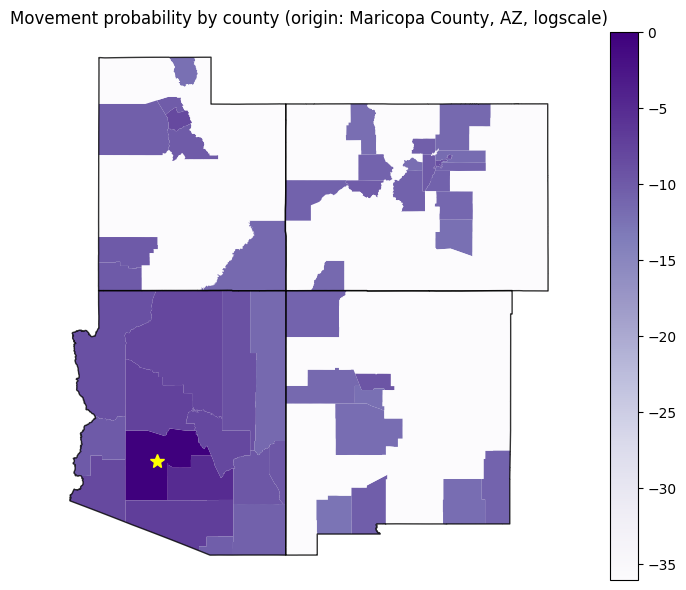

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

state_fips = tuple({STATE.truncate(x) for x in scope.node_ids})
gdf_counties = us_tiger.get_counties_geo(scope.year)  # type:ignore
gdf_counties = gdf_counties[gdf_counties["GEOID"].str.startswith(state_fips)]

gdf_states = us_tiger.get_states_geo(scope.year)  # type:ignore
gdf_states = gdf_states[gdf_states["GEOID"].str.startswith(state_fips)]

gdf_merged = gdf_counties.merge(
    pd.DataFrame(
        {
            "GEOID": scope.node_ids,
            "data": log_pei_kernel[MARICOPA_CO_IDX],
        }
    ),
    on="GEOID",
)


fig, ax = plt.subplots(figsize=(8, 6))
ax.axis("off")
ax.set_title("Movement probability by county (origin: Maricopa County, AZ, logscale)")
gdf_merged.plot(ax=ax, column="data", cmap="Purples", legend=True, vmax=0)
gdf_states.plot(ax=ax, linewidth=1, edgecolor="black", color="none", alpha=0.8)
# Get Maricopa County's centroid from the geo so we can mark it.
origin = centroid[MARICOPA_CO_IDX]
ax.plot(origin[0], origin[1], marker="*", color="yellow", markersize=10)
fig.tight_layout()
plt.show()